Enlace del ejemplo de Transfer Learning en Pytorch
[Fuente](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor)


In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
!wget  https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2019-11-20 23:05:01--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.33.174.53, 13.33.174.98, 13.33.174.125, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.33.174.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  18.9MB/s    in 2.4s    

2019-11-20 23:05:04 (18.9 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [0]:
import zipfile
with zipfile.ZipFile('/content/hymenoptera_data.zip', 'r') as zip_ref:
    zip_ref.extractall('hymenoptera_data')

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = 'drive/My Drive/Datasets/hymenoptera_data'
data_dir = '/content/hymenoptera_data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
image_datasets['val'].classes

['ants', 'bees']

In [6]:
torch.cuda.current_device()

0

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [7]:
class_names

['ants', 'bees']

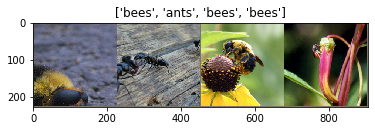

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.6MB/s]


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5657 Acc: 0.7213
val Loss: 0.2849 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.6546 Acc: 0.7213
val Loss: 0.2267 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5032 Acc: 0.8074
val Loss: 0.2520 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4765 Acc: 0.7910
val Loss: 0.2654 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.5209 Acc: 0.7992
val Loss: 0.2551 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.5092 Acc: 0.7869
val Loss: 0.2107 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3766 Acc: 0.8484
val Loss: 0.2437 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3044 Acc: 0.8689
val Loss: 0.1821 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3901 Acc: 0.8156
val Loss: 0.1693 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3247 Acc: 0.8525
val Loss: 0.1660 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3098 Acc: 0.8607
val Loss: 0.1854 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2806 Acc: 0.8770
val Loss: 0.1545 Acc: 0.9281

Ep

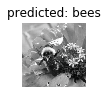

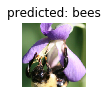

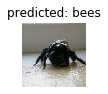

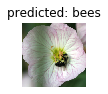

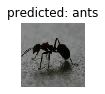

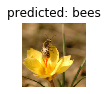

In [0]:
visualize_model(model_ft)

ConvNet as fixed feature extractor

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.5MB/s]


In [0]:
class_names

['ants', 'bees']

In [0]:

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6410 Acc: 0.6434
val Loss: 0.2445 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4209 Acc: 0.8197
val Loss: 0.2397 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.5253 Acc: 0.7582
val Loss: 0.6836 Acc: 0.7386

Epoch 3/24
----------
train Loss: 0.6088 Acc: 0.7500
val Loss: 0.2477 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.5187 Acc: 0.7869
val Loss: 0.2206 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4046 Acc: 0.8156
val Loss: 0.3172 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.3488 Acc: 0.8402
val Loss: 0.2084 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3065 Acc: 0.8484
val Loss: 0.2021 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2885 Acc: 0.8730
val Loss: 0.2081 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3485 Acc: 0.8279
val Loss: 0.1871 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3670 Acc: 0.8238
val Loss: 0.2085 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3576 Acc: 0.8033
val Loss: 0.1962 Acc: 0.9281

Ep

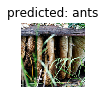

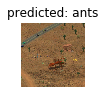

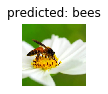

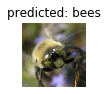

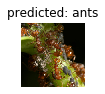

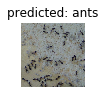

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [0]:
torch.save(model_conv.state_dict(), 'model_conv.pth')

In [0]:
model_conv_t = torchvision.models.resnet18(pretrained=True)
for param in model_conv_t.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_t.fc.in_features
model_conv_t.fc = nn.Linear(num_ftrs, 2)

model_conv_t = model_conv_t.to(device)


model_conv_t.load_state_dict(torch.load('model_conv.pth'))
model_conv_t.eval()

36.233333333333334

##resnet18 tl Probado y funcionando

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
image_datasets['train'] = image_datasets['train'].classes[1:]

In [0]:
class_names = class_names[1:] 

In [0]:
class_names

['ants', 'bees']

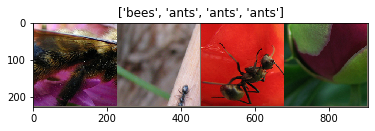

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    labels = labels-1
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            labels = labels-1
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5751 Acc: 0.7049
val Loss: 0.3977 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5303 Acc: 0.8156
val Loss: 0.4705 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.4763 Acc: 0.8320
val Loss: 0.3171 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.4784 Acc: 0.7951
val Loss: 0.4307 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.5073 Acc: 0.8238
val Loss: 0.2668 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4266 Acc: 0.8197
val Loss: 0.2407 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4640 Acc: 0.7787
val Loss: 0.3679 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3487 Acc: 0.8852
val Loss: 0.3486 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3780 Acc: 0.8607
val Loss: 0.3092 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.4229 Acc: 0.8361
val Loss: 0.2789 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3966 Acc: 0.8443
val Loss: 0.2819 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2549 Acc: 0.8975
val Loss: 0.2946 Acc: 0.9085

Ep

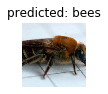

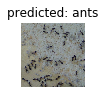

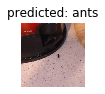

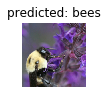

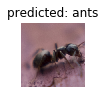

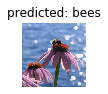

In [0]:
visualize_model(model_ft)

ConvNet as fixed feature extractor

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6686 Acc: 0.6148
val Loss: 0.1924 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5378 Acc: 0.7705
val Loss: 0.2961 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5581 Acc: 0.7787
val Loss: 0.2151 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5044 Acc: 0.7787
val Loss: 0.2520 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3835 Acc: 0.8525
val Loss: 0.1877 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.4225 Acc: 0.8238
val Loss: 0.2308 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4595 Acc: 0.8197
val Loss: 0.1835 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3510 Acc: 0.8730
val Loss: 0.2246 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3691 Acc: 0.8607
val Loss: 0.1657 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3696 Acc: 0.8320
val Loss: 0.1994 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3826 Acc: 0.8156
val Loss: 0.1702 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3475 Acc: 0.8730
val Loss: 0.1980 Acc: 0.9412

Ep

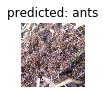

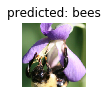

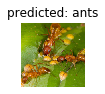

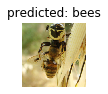

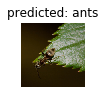

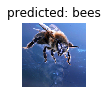

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [0]:
torch.save(model_conv.state_dict(), 'model_conv.pth')

In [0]:
model_conv_t = torchvision.models.resnet18(pretrained=True)
for param in model_conv_t.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_t.fc.in_features
model_conv_t.fc = nn.Linear(num_ftrs, 2)

model_conv_t = model_conv_t.to(device)


model_conv_t.load_state_dict(torch.load('model_conv.pth'))
model_conv_t.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

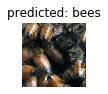

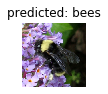

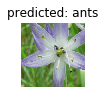

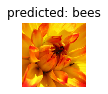

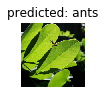

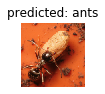

In [0]:
visualize_model(model_conv_t)

plt.ioff()
plt.show()

In [0]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()